In [ ]:
!pip install tensorflow==1.13.0rc1 -q -q
!pip install keras==2.0 -q 


ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.0rc1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0)
ERROR: No matching distribution found for tensorflow==1.13.0rc1
     |████████████████████████████████| 495.0 MB 34 kB/s 
     |████████████████████████████████| 463.8 MB 32 kB/s 
     |████████████████████████████████| 5.6 MB 49.6 MB/s 
     |████████████████████████████████| 462 kB 47.8 MB/s 
     |████████████████████████████████| 132 kB 49.9 MB

In [ ]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.stats import norm 

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda 
from tensorflow.keras.layers import concatenate, LeakyReLU 
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import binary_crossentropy 
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam, RMSprop 
from IPython.display import clear_output 
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard  

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

x_train = x_train.astype('float32') / 255. 
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

y_train_cat = to_categorical(y_train, 10).astype(np.float32) 
y_test_cat  = to_categorical(y_test, 10).astype(np.float32) 
num_classes = y_test_cat.shape[1] 

In [ ]:
batch_size = 500 
latent_dim = 8 
dropout_rate = 0.3 
start_lr = 0.001 

In [ ]:
def create_cvae(): 
    models = {} 
 
    def apply_bn_and_dropout(x): 
        return Dropout(dropout_rate)(BatchNormalization()(x)) 
 
    input_img = Input(shape=(28, 28, 1)) 
    flatten_img = Flatten()(input_img) 
    input_lbl = Input(shape=(num_classes,), dtype='float32') 

    x = concatenate([flatten_img, input_lbl]) 
    
    x = Dense(256, activation='relu')(x) 
    
    x = apply_bn_and_dropout(x) 
 
    z_mean = Dense(latent_dim)(x) 
    z_log_var = Dense(latent_dim)(x) 
 
    def sampling(args): 
        z_mean, z_log_var = args 
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
 
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l)  
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) 
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) 
 
    z = Input(shape=(latent_dim, )) 
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') 
    x = concatenate([z, input_lbl_d]) 
    x = Dense(256)(x)  
    x = LeakyReLU()(x) 
    x = Dense(28*28, activation='sigmoid')(x) 
    decoded = Reshape((28, 28, 1))(x)  

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') 
 
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
 
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): 
        x = K.reshape(x, shape=(batch_size, 28*28)) 
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) 
        xent_loss = 28*28*binary_crossentropy(x, decoded) 
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return (xent_loss + kl_loss)/2/28/28

    return models, vae_loss

models, vae_loss = create_cvae() 
cvae = models["cvae"] 
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
digit_size = 28 
def plot_digits(*args, invert_colors=False): 
    args = [x.squeeze() for x in args] 
    n = min([x.shape[0] for x in args]) 
    figure = np.zeros((digit_size * len(args), digit_size * n)) 

    for i in range(n):
        for j in range(len(args)): 
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: 
        figure = 1-figure 

    plt.figure(figsize=(2*n, 2*len(args))) 
    plt.imshow(figure, cmap='Greys_r') 
    plt.grid(False) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
    plt.show() 


n = 15 


In [ ]:
save_epochs = set([i*5 for i in range(0,25)])
 
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10
 
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

 
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() 
 
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

 
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

tb     = TensorBoard(log_dir='./logs')

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss)


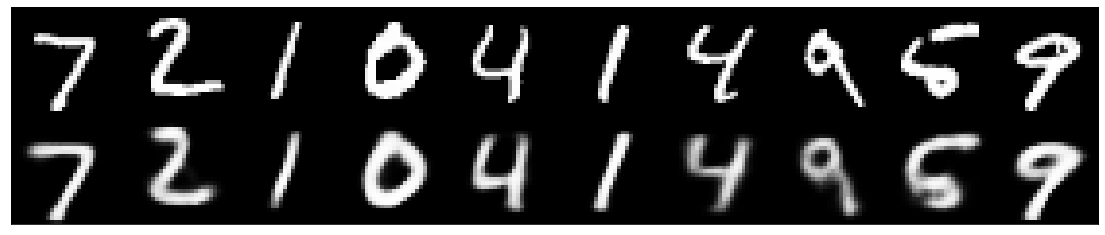

60000/60000 [==============================] - 8s 132us/sample - loss: 0.0720 - val_loss: 0.0695
Epoch 47/50
60000/60000 [==============================] - 8s 130us/sample - loss: 0.0719 - val_loss: 0.0696
Epoch 48/50
60000/60000 [==============================] - 8s 133us/sample - loss: 0.0719 - val_loss: 0.0694
Epoch 49/50
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0718 - val_loss: 0.0694
Epoch 50/50
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0717 - val_loss: 0.0693


In [ ]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=50,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) 

In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): 
    rows = X.shape[0] 
    if isinstance(lbl_in, int): 
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) 
        lbl_in[:, lbl] = 1  
    if isinstance(lbl_out, int): 
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) 
        lbl_out[:, lbl] = 1 
 
    return model.predict([X, lbl_in, lbl_out]) 

# Эксперимент 

In [ ]:
n = 10

prot = np.random.random(size=(10, 28, 28, 1)) 

## Эксперимент 1 (label = 1)

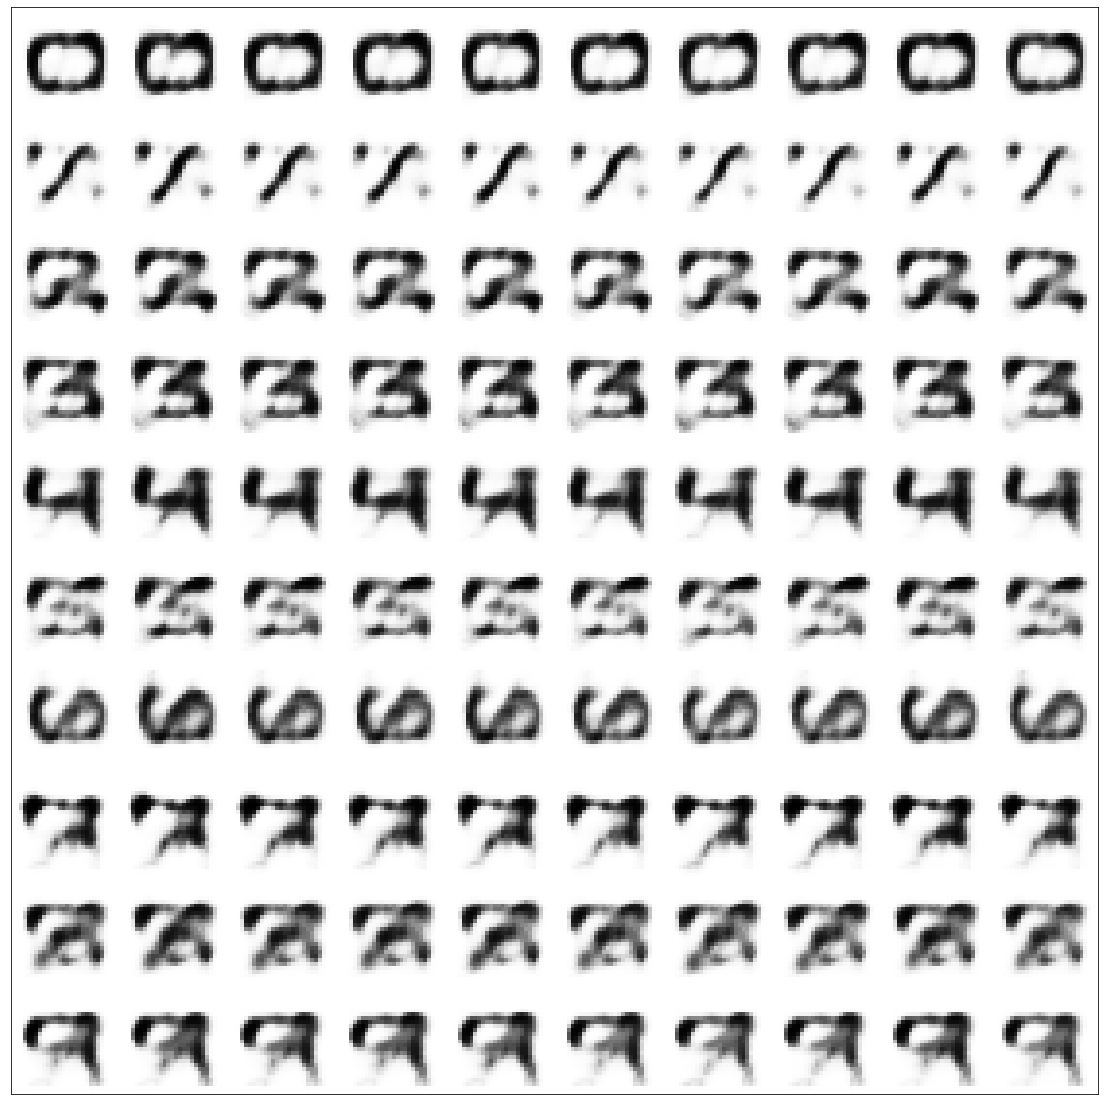

In [ ]:
lbl = 1
generated = [] 

for i in range(num_classes): 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 
 
plot_digits(*generated, invert_colors=True) 

## Эксперимент 2 (label = 3)

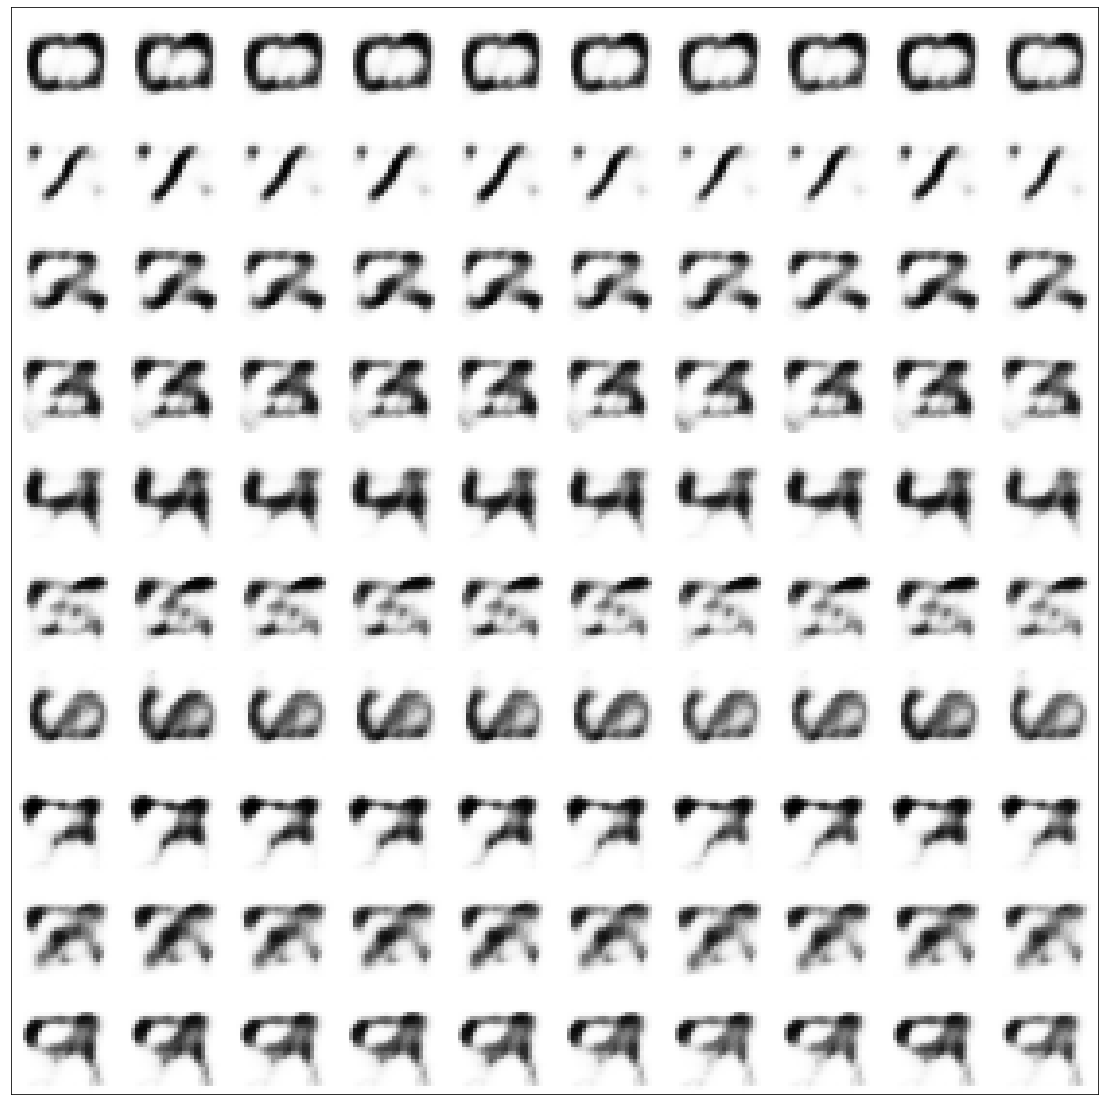

In [ ]:
lbl = 3
generated = [] 

for i in range(num_classes): 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 
 
plot_digits(*generated, invert_colors=True) 

## Эксперимент 3 (label = 5)

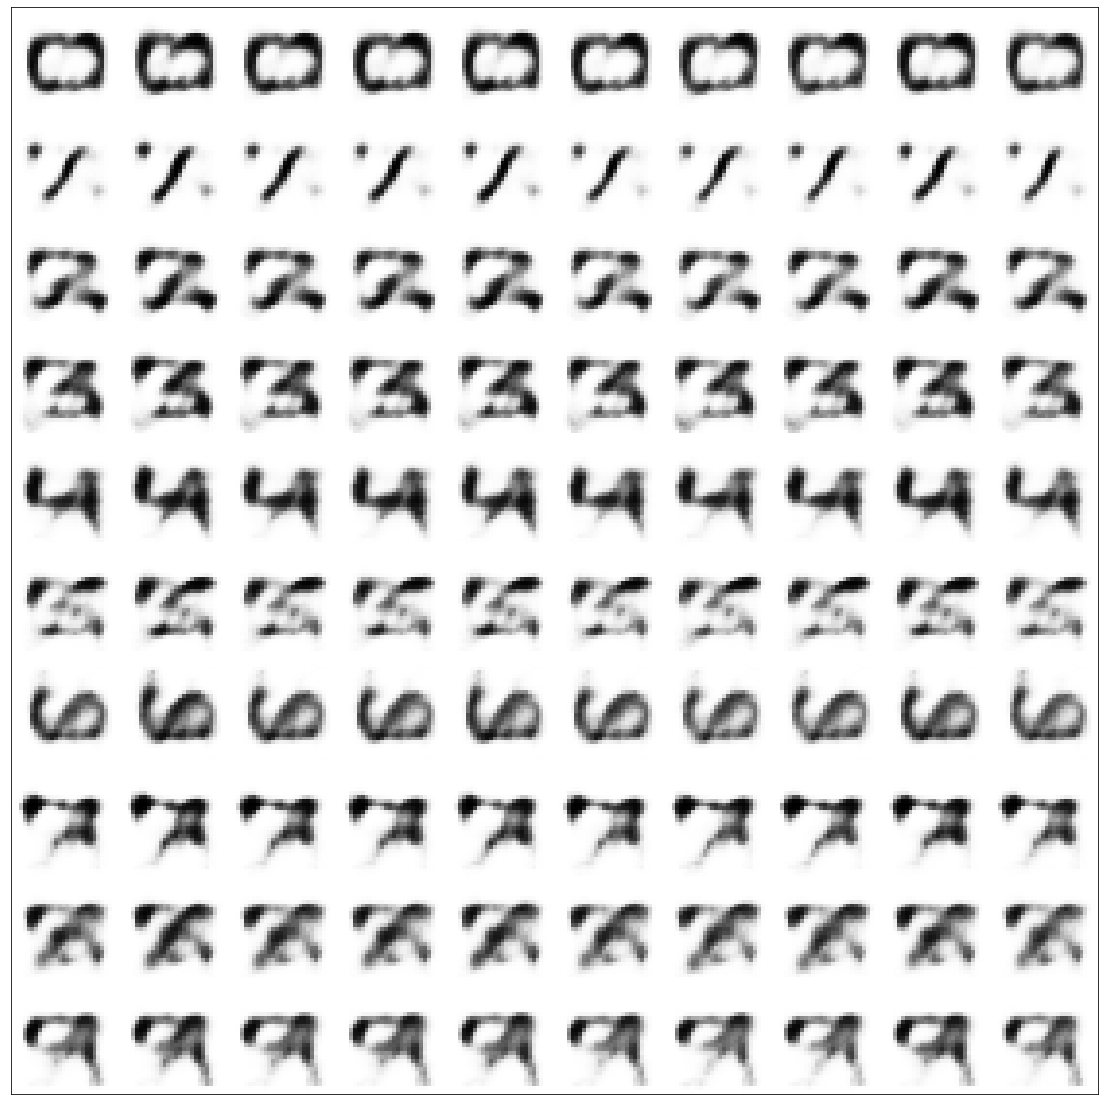

In [ ]:
lbl = 5
generated = [] 

for i in range(num_classes): 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 
 
plot_digits(*generated, invert_colors=True) 

## Эксперимент 4 (label = 7)

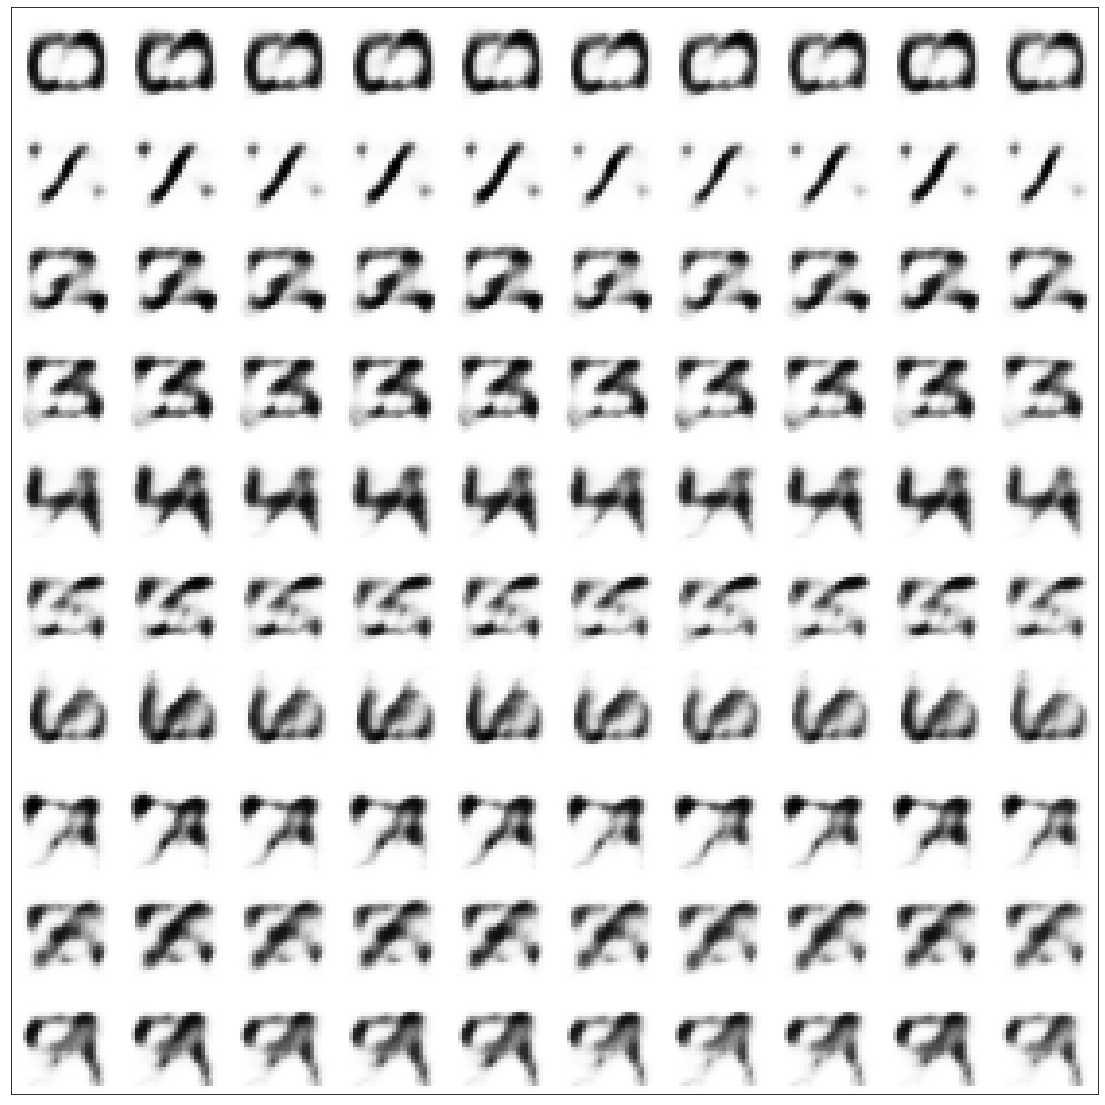

In [ ]:
lbl = 7
generated = [] 

for i in range(num_classes): 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 
 
plot_digits(*generated, invert_colors=True) 

## Эксперимент 5 (label = 9)

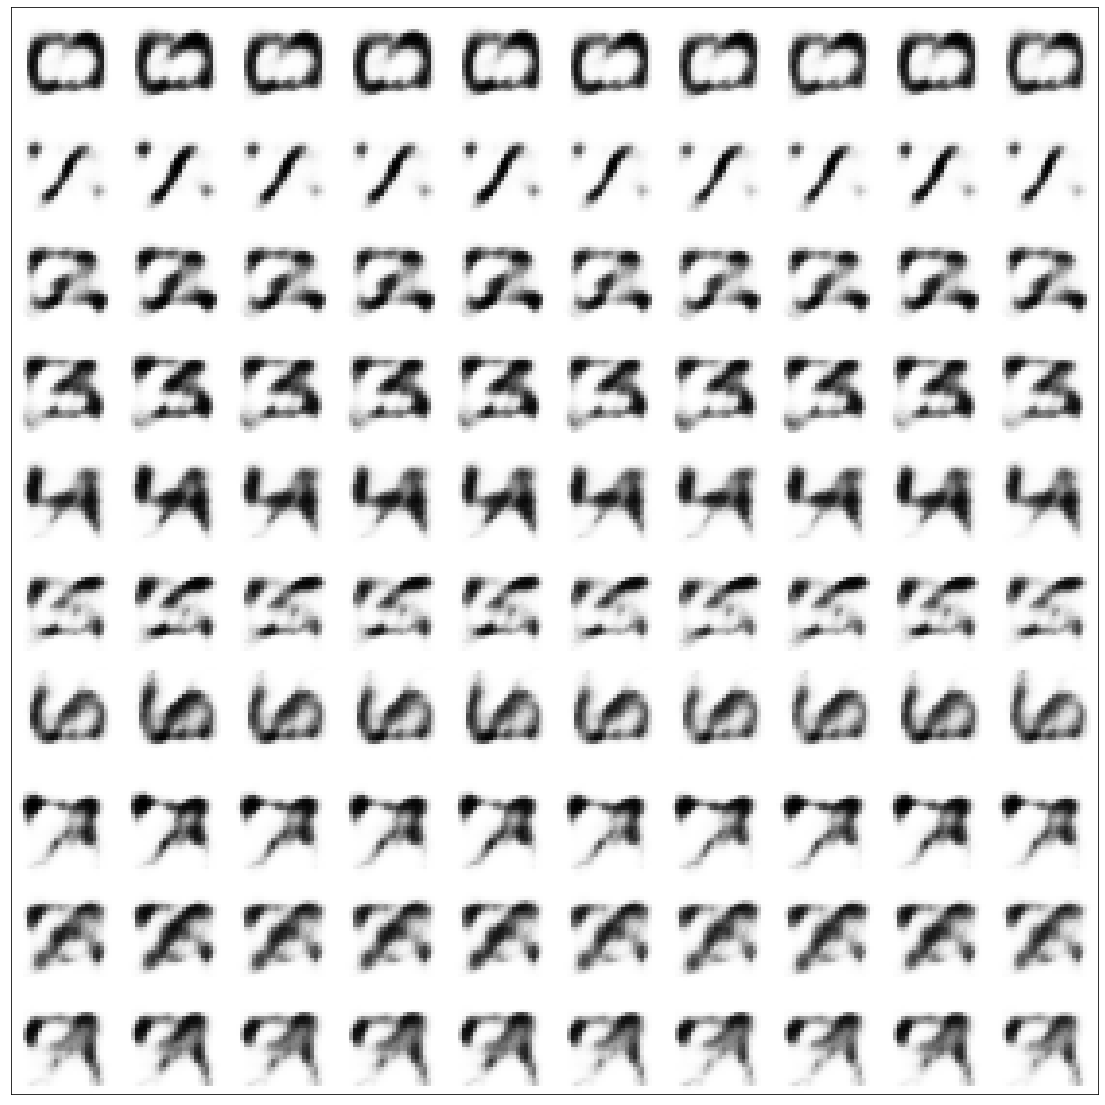

In [ ]:
lbl = 9
generated = [] 

for i in range(num_classes): 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 
 
plot_digits(*generated, invert_colors=True) 